In [1]:
import os
import shutil
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model, layers, optimizers, callbacks, models
from tensorflow.keras.utils import plot_model

Captcha Count: 1070
Charset Count: 19


Text(0.5, 1.0, 'Charset count')

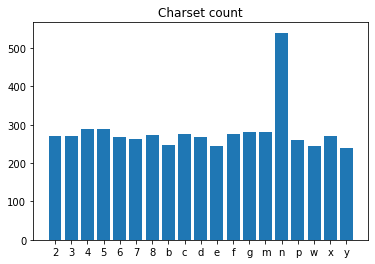

In [2]:
# data analyzing
path = "./samples/"
captcha_data = []
char_dict = {}

for captcha in os.listdir(path):
    captcha_data.append(captcha)
    captcha_chars = captcha.split(".")[0]
    for char in captcha_chars:
        char_dict[char] = char_dict.get(char, 0) + 1

char_set = list(char_dict.keys())
char_set.sort()
char_count = [char_dict[char] for char in char_set]

print(f"Captcha Count: {len(captcha_data)}")
print(f"Charset Count: {len(char_set)}")

# plot
plt.bar(char_set, char_count)
plt.title("Charset count")

In [3]:
# prepare data
n_data = len(captcha_data)
n_charset = len(char_set)
n_captcha = len(captcha_data[0].split(".")[0])
img_shape = (50, 200, 1)
X_shape = (n_data, img_shape[0], img_shape[1], img_shape[2])
y_shape = (n_captcha, n_data, n_charset)

X = np.zeros(X_shape)
y = np.zeros(y_shape)

for i, captcha in enumerate(captcha_data):
    # get captcha img - create X
    captcha_img = Image.open(os.path.join(path, captcha))
    captcha_img = captcha_img.convert("L")
    captcha_img = np.array(captcha_img, dtype=float)
    captcha_img /= 255.0
    captcha_img = np.resize(captcha_img, (captcha_img.shape[0], captcha_img.shape[1], 1))

    # get captcha code - create y
    captcha_code = captcha.split(".")[0]
    targs = np.zeros((5, len(char_set)))
    
    for idx, char in enumerate(captcha_code):
        targs[idx, char_set.index(char)] = 1.0

    # add to X & y
    X[i] = captcha_img
    y[:, i] = targs

print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")

X.shape = (1070, 50, 200, 1)
y.shape = (5, 1070, 19)


In [4]:
# get model
def get_model():
    input_tensor = Input(shape=X[0].shape)
    x = layers.Conv2D(32, (5, 5), padding="valid", activation="relu")(input_tensor)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2), padding="same")(x)
    x = layers.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x_out = layers.MaxPooling2D((2,2),padding='same')(x)

    output_list = []
    for i in range(5):
        x = layers.Conv2D(256, (3, 3), padding="same", activation="relu")(x_out)
        x = layers.MaxPooling2D((2, 2), padding="same")(x)
        x = layers.Flatten()(x)
        x = layers.Dropout(0.5)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dropout(0.5)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(n_charset, activation="softmax", name=f"char_{i}")(x)
        output_list.append(x)

    model = Model(inputs=input_tensor, outputs=output_list)
    return model

In [5]:
# compile model
def compile_model():
    loss_fn = "categorical_crossentropy"
    optimizer = optimizers.Adam(learning_rate=5e-4)
    metrics = ["accuracy"]
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=metrics)

In [6]:
# train model
def train_model(X, y):
    X_train = X
    y_train = [y[i] for i in range(n_captcha)]
    tensorboard_log_dir = "./logs/"
    csv_log_file = "./training_log.csv"
    callback_list = [
        callbacks.ReduceLROnPlateau(patience=3, factor=0.5),
        callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True),
        callbacks.TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1),
        callbacks.CSVLogger(csv_log_file),
    ]
    shutil.rmtree(tensorboard_log_dir)
    os.remove(csv_log_file)
    print("Previous logs cleared.")
    model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.2, shuffle=True, callbacks=callback_list)

In [7]:
# save model
def save_model(to_file):
    model.save(to_file)

In [8]:
# predict captcha
def predict_captcha(captcha_img):
    X = np.reshape(captcha_img, (1, 50, 200, 1))
    y = model.predict(X)
    res = np.reshape(y, (5, 19))
    label = "".join([char_set[np.argmax(i)] for i in res])
    return label

In [9]:
model = get_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 46, 196, 32)  832         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 23, 98, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 23, 98, 64)   18496       max_pooling2d[0][0]              
______________________________________________________________________________________________

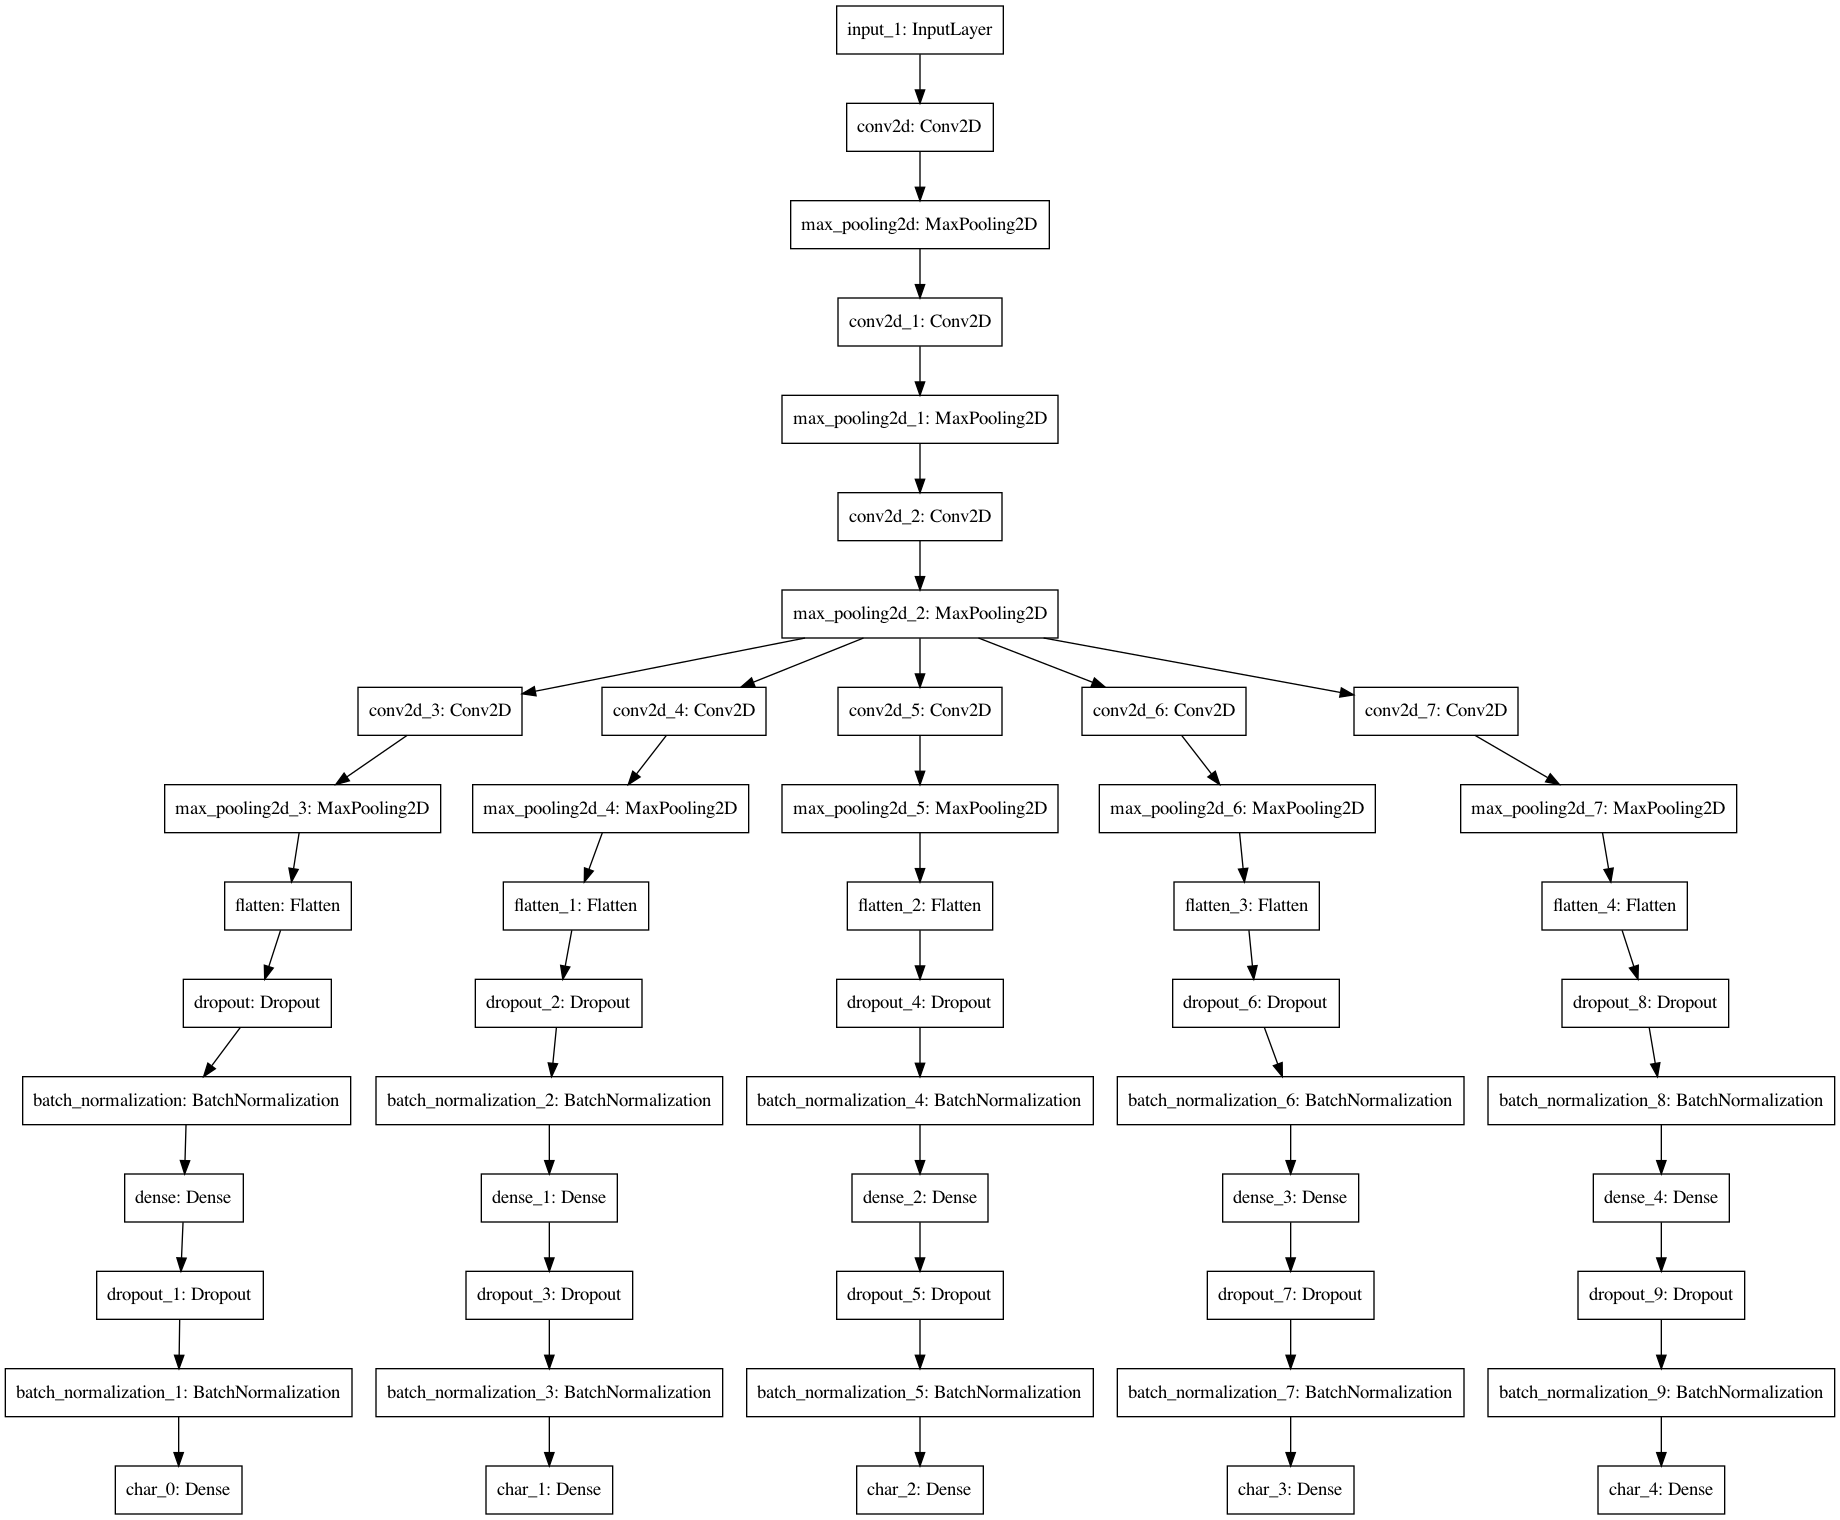

In [10]:
plot_model(model, to_file="./figures/captcha_model.png")

In [11]:
compile_model()
train_model(X, y)
print("Done!")

Previous logs cleared.
Epoch 1/30
27/27 [==============================] - 15s 443ms/step - loss: 18.0348 - char_0_loss: 3.5082 - char_1_loss: 3.6973 - char_2_loss: 3.5578 - char_3_loss: 3.6749 - char_4_loss: 3.5966 - char_0_accuracy: 0.0550 - char_1_accuracy: 0.0731 - char_2_accuracy: 0.0497 - char_3_accuracy: 0.0502 - char_4_accuracy: 0.0548 - val_loss: 14.7284 - val_char_0_loss: 2.9359 - val_char_1_loss: 2.9472 - val_char_2_loss: 2.9535 - val_char_3_loss: 2.9501 - val_char_4_loss: 2.9417 - val_char_0_accuracy: 0.0935 - val_char_1_accuracy: 0.0421 - val_char_2_accuracy: 0.0607 - val_char_3_accuracy: 0.0514 - val_char_4_accuracy: 0.0561
Epoch 2/30
27/27 [==============================] - 11s 401ms/step - loss: 17.7234 - char_0_loss: 3.5290 - char_1_loss: 3.5316 - char_2_loss: 3.5548 - char_3_loss: 3.5904 - char_4_loss: 3.5175 - char_0_accuracy: 0.0553 - char_1_accuracy: 0.0427 - char_2_accuracy: 0.0448 - char_3_accuracy: 0.0580 - char_4_accuracy: 0.0574 - val_loss: 14.7603 - val_char_

In [12]:
save_model(to_file="./model/captcha_model.h5")

In [13]:
df = pd.read_csv("./training_log.csv")
df.columns.values.tolist()

['epoch',
 'char_0_accuracy',
 'char_0_loss',
 'char_1_accuracy',
 'char_1_loss',
 'char_2_accuracy',
 'char_2_loss',
 'char_3_accuracy',
 'char_3_loss',
 'char_4_accuracy',
 'char_4_loss',
 'loss',
 'lr',
 'val_char_0_accuracy',
 'val_char_0_loss',
 'val_char_1_accuracy',
 'val_char_1_loss',
 'val_char_2_accuracy',
 'val_char_2_loss',
 'val_char_3_accuracy',
 'val_char_3_loss',
 'val_char_4_accuracy',
 'val_char_4_loss',
 'val_loss']

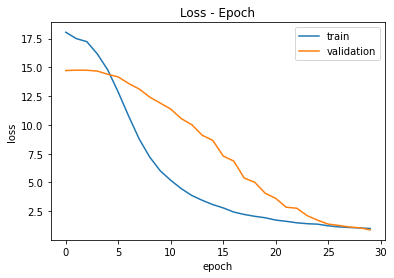

In [14]:
plt.plot(df["epoch"], df[["loss", "val_loss"]])
plt.legend(["train", "validation"])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss - Epoch")
plt.savefig("./figures/Loss_Epoch.png")
plt.show()

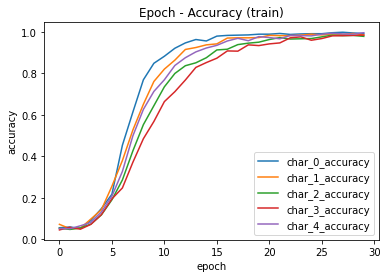

In [15]:
plt.plot(df["epoch"], df[[f"char_{i}_accuracy" for i in range(5)]])
plt.legend([f"char_{i}_accuracy" for i in range(5)])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Epoch - Accuracy (train)")
plt.savefig("./figures/Epoch_Accuracy_train.png")
plt.show()

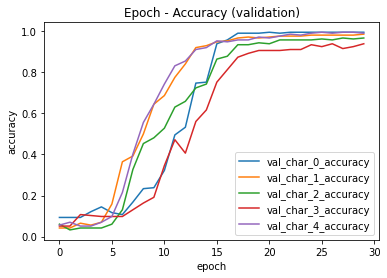

In [16]:
plt.plot(df["epoch"], df[[f"val_char_{i}_accuracy" for i in range(5)]])
plt.legend([f"val_char_{i}_accuracy" for i in range(5)])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Epoch - Accuracy (validation)")
plt.savefig("./figures/Epoch_Accuracy_validation.png")
plt.show()

<ipython-input-17-09a950c9c512>:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


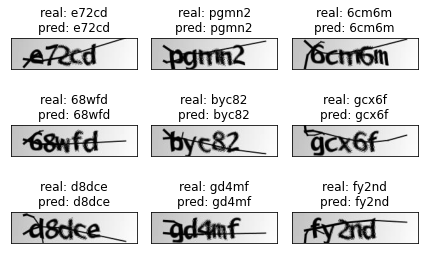

In [17]:
fig = plt.figure()
for i in range(3):
    for j in range(3):
        idx = i + 3 * j + 1
        real = captcha_data[idx].split(".")[0]
        pred = predict_captcha(X[idx])
        ax = fig.add_subplot(3, 3, idx)
        ax.imshow(np.resize(X[idx], (50, 200)), cmap=plt.cm.gray)
        ax.set_title(f"real: {real}\npred: {pred}")
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()
fig.savefig("./figures/Predict.png")
fig.show()